In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow.python.ops import parallel_for as pfor
import sys
import json
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
from numpy import linalg as LA
from sklearn import linear_model
from sklearn.manifold import MDS
from sklearn.neighbors import DistanceMetric
from scipy.spatial import distance
from sklearn.cluster import KMeans

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from tools_lnd import get_T_inds, plot_FP, plot_N, TDR_axes, out_axes
from tools_lnd import make_axes, same_stim_trial, generate_Beta_epoch, take_names, gen_X_from_model_dir_epoch
from tools_lnd import make_h_trial_rule, get_model_params, gen_trials_from_model_dir, gen_X_from_model_dir
from tools_lnd import comp_eig_decomp, make_FP_axs, make_Beta, vanilla_run_with_h0


In [2]:
task_list = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti']

rule_set_names = ['DelayGo', 'ReactGo', 'MemoryGo', 'DelayAnti', 'ReactAnti', 'MemoryAnti']

In [6]:
model_n = 0
task_list = ['fdgo', 'fdanti', 'delaygo', 'delayanti']
rule = task_list[0]
which_net = 'l2w0001'
fldr = 'all'#''4_tasks'
supp = []#'long_train'

if fldr == '4_tasks':
    s = '_'
    rule_trains_str = s.join(task_list)
    file_spec = os.path.join(fldr,which_net+'_'+rule_trains_str)
else:
    file_spec = which_net
    
dir_specific_all = os.path.join('crystals','softplus',file_spec)#,supp)
    
m = os.path.join(p,'data/rnn/multitask/',net,dir_specific_all,str(model_n))

figpath = os.path.join(p,'code','overleaf','multitask-nets','v1_figs','identify_rel_fps')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [7]:
model = Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    trial = generate_trials(rule, hparams, mode='random', noise_on=False, batch_size = 128, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
    
    n_input = hparams['n_input']
    n_rnn = hparams['n_rnn']
    n_output = hparams['n_output']
    w_in = params[0]
    b_in = params[1]
    w_out = params[2]
    b_out = params[3]
    sigma_rec = 0#hparams['sigma_rec']
    dt = hparams['dt']
    tau = hparams['tau']
    alpha = dt/tau
    activation = hparams['activation']

# if activation == 'softplus':
#     _activation = lambda x: np.log(np.exp(x) + 1)
# elif activation == 'tanh':
#     _activation = lambda x: np.tanh(x)
# elif activation == 'relu':
#     _activation = lambda x: x * (x > 0)
# elif activation == 'power':
#     _activation = lambda x: (x * (x > 0))**2
# elif activation == 'retanh':
#     _activation = lambda x: np.tanh(x * (x > 0))

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


In [40]:
def plot_N3D(X, D, clist, linewidth = 1, alpha = .5, linestyle = '-'):
    """Plot activity is some 2D space.

        Args:
            X: neural activity in Trials x Time x Neurons
            D: Neurons x 2 plotting dims
        """

    cmap=plt.get_cmap('rainbow')
    S = np.shape(X)[0]
    
    for s in range(S):

        if isinstance(c_list, str) :
            c = clist
        else:
            c = cmap(clist[s]/max(clist))

        X_trial = np.dot(X[s,:,:],D.T)
#         ax.scatter3D(X_trial[-1,0],X_trial[-1,1],X_trial[-1,2],'^',c = c, linewidth = linewidth, alpha = alpha)
        ax.plot3D(X_trial[:,0],X_trial[:,1],X_trial[:,2],linestyle,c = c, linewidth = linewidth, alpha = alpha)
#         ax.scatter3D(X_trial[0,0],X_trial[0,1],X_trial[0,2],'.',c = c, linewidth = linewidth, alpha = alpha)
        
def plot_FP_jitter_3D(ax,m,D_use,rule,t_num,fp_epoch,sorted_fps,fp_inds,eig_decomps,
                   xlabel = 'FP set PC1',ylabel = 'FP set PC2',rand_step_coef = 0.1,n_steps = 100,
                   lw = 3,al = .6,linestyle = '-',n_jit = 0,c = 'k'):

    cmap=plt.get_cmap('rainbow')
        
    model = Model(m)
    with tf.Session() as sess:
        model.restore()
        model._sigma=0
        hparams = model.hp
        alpha = hparams['dt']/hparams['tau']
        var_list = model.var_list
        params = [sess.run(var) for var in var_list]

        trial = generate_trials(rule, hparams, mode='test',noise_on=False)
        feed_dict = tools.gen_feed_dict(model, trial, hparams)
        h_tf, _ = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
        T,S,N = np.shape(h_tf)
        T_inds = get_T_inds(trial,fp_epoch) # grab epoch time indexing
        x_t = np.matlib.repmat(trial.x[T_inds[1],t_num,:],n_steps,1)
        
        for fp_ind in fp_inds:
            for jit in range(n_jit):
                h0 = sorted_fps[fp_ind,:] + rand_step_coef*npr.randn(N)
                h_t = vanilla_run_with_h0(params, x_t, h0, hparams)
                jitter = np.dot(h_t,D_use)
                ax.plot3D(jitter[:,0],jitter[:,1],jitter[:,2],'-',c = 'k',linewidth = .1)
              
            
#             if np.max(eig_decomps[fp_ind]['evals'].real)<1:
#                 markerfacecolor = c
#             else:
#                 markerfacecolor = 'None'
#             X_trial = np.dot(sorted_fps[fp_ind],D_use)
#             ax.plot3D(X_trial[0], X_trial[1], X_trial[2], 'o', 
#                      markerfacecolor = markerfacecolor, markeredgecolor = c, markersize = 10, alpha = .5)

             
        for jit in range(1):
            h0 = h_tf[T_inds[0],t_num,:]
            h_t = vanilla_run_with_h0(params, x_t, h0, hparams)
            jitter = np.dot(h_t,D_use)
            ax.plot3D(jitter[:,0],jitter[:,1],jitter[:,2],'-',c = c,linewidth = 2)


In [63]:
task_list = ['fdgo','delaygo','fdanti','delayanti',]
Beta_qr,Y_labels = make_Beta(m,task_list,'stim1',ind=-1)
use_yinds = [0,2,3]
axes_label1 = Y_labels[use_yinds[0]]
axes_label2 = Y_labels[use_yinds[1]]
axes_label3 = Y_labels[use_yinds[2]]
D_use = Beta_qr[:,use_yinds]
D_use[:,2] = -D_use[:,2]

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


In [8]:
epoch = 'stim1'
f = os.path.join(m,'tf_fixed_pts_all_init',rule,epoch+'_'+str(324)+'.0.npz')
D_use,_,_ = make_FP_axs(f,m,'fdanti',epoch,axs ='pca', clust = 'False')
axes_label1 = 'pca_1'
axes_label2 = 'pca_2'
axes_label3 = 'pca_3'

In [7]:
%matplotlib

Using matplotlib backend: MacOSX


In [9]:
from sklearn.decomposition import PCA
from tools_lnd import make_h_all

rule = 'reactanti'
h_all_byepoch, h_all_byrule = make_h_all(m)
X_rule = h_all_byrule[rule]
X_use = np.reshape(X_rule[:],(-1,hparams['n_rnn']))

pca = PCA(n_components = 10)
fp_pca = pca.fit_transform(X_use)
D_use = pca.components_.T
axes_label1 = 'pca_1'
axes_label2 = 'pca_2'
axes_label3 = 'pca_3'

Overwrite sigma_rec with 0.000
0.0
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


In [21]:
%matplotlib

Using matplotlib backend: MacOSX


In [41]:
fp_project = np.dot(sorted_fps,D_use)

In [46]:
########## X TASK ###########
# from mpl_toolkits.mplot3d import Axes3D
plt.rcParams.update({'font.size': 14})
from mpl_toolkits import mplot3d
from itertools import compress 
fig = plt.figure(figsize=(10,10),tight_layout=True,facecolor='white')

for offset in [0,]:#range(0,360,36):# 144
    t_set = [(offset)%360, (offset+180)%360]
    trial_num = [int(offset/4.5),int(offset/4.5)]
    trial_set = range(0,80,8)

    rule_set = ['reactgo','reactanti']
    epoch_set = ['fix1','fix1']
    step_file = 'interp_tasks'
    linestyle = ['-','--']
    n_interp = 20

    trial_str = '_'.join(str(round(t,2)) for t in t_set[:len(rule_set)])
    rule_str = '_'.join(str(r) for r in rule_set)
    epoch_str = '_'.join(str(r) for r in epoch_set[:len(rule_set)])

    cmap_grad = plt.get_cmap('plasma')
    cmap_discrete = ['darkorchid','orange']
    ax = fig.add_subplot(111, projection='3d')
    w_color = .005
    ax.w_xaxis.set_pane_color ((w_color, w_color, w_color, w_color))
    ax.w_yaxis.set_pane_color ((w_color, w_color, w_color, w_color))
    ax.w_zaxis.set_pane_color ((w_color, w_color, w_color, w_color))

    for ri in range(len(rule_set)):
        rule = rule_set[ri]
        trial = gen_trials_from_model_dir(m,rule,noise_on = False)
        epoch = epoch_set[ri]

        f = os.path.join(m,'tf_fixed_pts_all_init',rule,epoch+'_'+str(t_set[ri])+'.0.npz')
        fp_struct = np.load(f)
        sorted_fps = fp_struct['xstar']
        fp_inds = range(len(sorted_fps))
        eig_decomps = comp_eig_decomp(fp_struct['J_xstar'])

        plot_FP_jitter_3D(ax,m,D_use,rule,trial_num[0],epoch,sorted_fps,fp_inds,eig_decomps,
               rand_step_coef = 0.1, al = 1, linestyle = linestyle, n_steps = 300, 
                   n_jit = 1,c = cmap_discrete[ri])

        _,x = gen_X_from_model_dir(m,trial)
        T_inds = get_T_inds(trial,epoch)
        x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))

        #color by stim
        c_list = np.min(trial.stim_locs[:,[0,2]],axis=1)

        #color by target
    #     c_list = trial.y_loc[-1,:]

        plot_N3D(x_epoch[trial_set,:,:],D_use.T,c_list[trial_set],linewidth = 1, linestyle = linestyle[ri],alpha = .3)
    
        fp_project = np.dot(sorted_fps,D_use)
        stable_fps = [np.max(eig_decomps[fp_ind]['evals'])<1 for fp_ind in range(len(eig_decomps))]
        stable_fps_arg = list(compress(range(len(stable_fps)), stable_fps)) 

        ax.plot3D(fp_project[:,0],fp_project[:,1],fp_project[:,2],'o',c = cmap_discrete[ri],
                 markersize = 10, markerfacecolor = 'none', alpha = 1,linewidth = 5)
        ax.plot3D(fp_project[stable_fps_arg,0],fp_project[stable_fps_arg,1],fp_project[stable_fps_arg,2],
                   'o',c = cmap_discrete[ri],markersize = 10, alpha = 1,linewidth = 5)
    
    #     c_list = cmap_discrete[ri]
    #     highlight_trial = [trial_num[0],]
    #     plot_N3D(x_epoch[highlight_trial,:,:],D_use.T,c_list,linewidth = 3, linestyle = '-',alpha = 1)

    #     for step_i in range(n_interp):

    #         #a couple diff versions on filenames atm
    # #         f = rule_set[0]+'_'+rule_set[1]+'_'+epoch_set[0]+'_'+str(t_set[0])+'_step_'+str(step_i)#'_'+str(t_set[1])

    #         f = rule_str+'_'+epoch_str+'_'+trial_str+'_step_'+str(step_i)
    # #         f = rule_str+'_'+'go1'+'_'+trial_str+'_step_'+str(step_i)

    #         filename = os.path.join(m,step_file,rule_set[0]+'_'+rule_set[1],f+'.npz')
    #         fp_struct = np.load(filename)
    #         step_fps = fp_struct['xstar']

    #         fp_project = np.dot(step_fps,D_use)
    #         ax.plot3D(fp_project[:,0],fp_project[:,1],fp_project[:,2],'.',markersize = 3,c = cmap_grad(step_i/n_interp))

    tit = '1 TASK '+rule_str+'_'+epoch_str+'_'+trial_str
    ax.text2D(0.05, 0.95, tit, transform=ax.transAxes)
    ax.set_xlabel(axes_label1,fontsize = 18)
    ax.set_ylabel(axes_label2,fontsize = 18)
    ax.set_zlabel(axes_label3,fontsize = 18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if not os.path.exists(os.path.join(figpath,step_file,axes_label1)):
        os.makedirs(os.path.join(figpath,step_file,axes_label1))
    figname = tit+'_'+step_file+'_'+str(t_set[0])
    plt.savefig(os.path.join(figpath,step_file,axes_label1,figname+'.pdf'))
    plt.savefig(os.path.join(figpath,step_file,axes_label1,figname+'.png'))
#     ax.set_xlim((-3, 3))
#     ax.set_ylim((-5, 5))
#     ax.set_zlim((-5, 5))
    ax.view_init(10, 60)
    plt.show()
#     pdb.set_trace()

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitas

In [290]:
########## X EPOCH ###########
# from mpl_toolkits.mplot3d import Axes3D
plt.rcParams.update({'font.size': 14})
from mpl_toolkits import mplot3d
from itertools import compress 
fig = plt.figure(figsize=(10,10),tight_layout=True,facecolor='white')

offset = 2*8
trial_num = [offset,offset+8]
ins = [trial_num[0]*36/8, trial_num[1]*36/8]
t_set = [(180+ins[0])%360, (180+ins[1])%360]
trial_set = range(0,80,8)

rule_set = ['fdanti','fdanti']
epoch_set = ['stim1','stim1']
step_file = 'interp_stim'
linestyle = ['-','--']
n_interp = 20
    
trial_str = '_'.join(str(round(t,2)) for t in t_set)
rule_str = '_'.join(str(r) for r in rule_set)
epoch_str = '_'.join(str(r) for r in epoch_set)

task_list = ['fdgo','delaygo','fdanti','delayanti',]
Beta_qr,Y_labels = make_Beta(m,task_list,'stim1',ind=-1)
use_yinds = [2,3,0]
axes_label1 = Y_labels[use_yinds[0]]
axes_label2 = Y_labels[use_yinds[1]]
axes_label3 = Y_labels[use_yinds[2]]
D_use = Beta_qr[:,use_yinds]

cmap_grad = plt.get_cmap('plasma')
cmap_discrete = ['darkorchid','orange']
ax = fig.add_subplot(111, projection='3d')
w_color = .005
ax.w_xaxis.set_pane_color ((w_color, w_color, w_color, w_color))
ax.w_yaxis.set_pane_color ((w_color, w_color, w_color, w_color))
ax.w_zaxis.set_pane_color ((w_color, w_color, w_color, w_color))

for ri in range(len(t_set)):
    rule = rule_set[ri]
    trial = gen_trials_from_model_dir(m,rule,noise_on = False)
    epoch = epoch_set[ri]

    
    f = os.path.join(m,'tf_fixed_pts_all_init',rule,epoch+'_'+str(t_set[ri])+'.npz')
    fp_struct = np.load(f)
    sorted_fps = fp_struct['xstar']
    fp_inds = range(len(sorted_fps))
    eig_decomps = comp_eig_decomp(fp_struct['J_xstar'])

    plot_FP_jitter_3D(ax,m,D_use,rule,trial_num[ri],epoch,sorted_fps,fp_inds,eig_decomps,
           rand_step_coef = 0.1, al = 1, linestyle = linestyle, n_steps = 300, 
               n_jit = 0,c = cmap_discrete[ri])

    _,x = gen_X_from_model_dir(m,trial)
    T_inds = get_T_inds(trial,epoch)
    x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))
    c_list = np.min(trial.stim_locs[:,[0,2]],axis=1)
#     c_list = trial.y_loc[-1,:]
    plot_N3D(x_epoch[trial_set,:,:],D_use.T,c_list[trial_set],linewidth = 6, linestyle = linestyle[ri],alpha = .3)
#     c_list = cmap_discrete[ri]
#     highlight_trial = [trial_num[0],]
#     plot_N3D(x_epoch[highlight_trial,:,:],D_use.T,c_list,linewidth = 3, linestyle = '-',alpha = 1)

    for step_i in range(n_interp):
#         f = rule_set[0]+'_'+rule_set[1]+'_'+epoch_set[0]+'_'+str(t_set[0])+'_step_'+str(step_i)#'_'+str(t_set[1])
        
#         f = rule_str+'_'+epoch_str+'_'+trial_str+'_step_'+str(step_i)
#         f = rule_str+'_'+'go1'+'_'+trial_str+'_step_'+str(step_i)
        f = rule_set[0]+'_'+'stim1'+'_'+trial_str+'_step_'+str(step_i)
        filename = os.path.join(m,step_file,rule_set[0],f+'.npz')
        fp_struct = np.load(filename)
        step_fps = fp_struct['xstar']

        fp_project = np.dot(step_fps,D_use)
        ax.plot3D(fp_project[:,0],fp_project[:,1],fp_project[:,2],'.',markersize = 3,c = cmap_grad(step_i/n_interp))
# #         plt.show()

tit = 'X TASK '+rule_str+'_'+epoch_str+'_'+trial_str
# plt3D.title(tit,fontsize = 18)
ax.set_xlabel(axes_label1,fontsize = 18)
ax.set_ylabel(axes_label2,fontsize = 18)
ax.set_zlabel(axes_label3,fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

if not os.path.exists(os.path.join(figpath,step_file)):
    os.makedirs(os.path.join(figpath,step_file))
figname = tit+'_'+step_file+'_'+str(t_set[0])
plt.savefig(os.path.join(figpath,step_file,figname+'.pdf'))
plt.savefig(os.path.join(figpath,step_file,figname+'.png'))
plt.show()

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float3

In [71]:
def plot_fp_struct_multicolor(m,tasks,trial_set,D,fp_epoch,sorted_fps,eig_decomps,q_star,do_plot_FP = 1,
                              t_num = 0,qlim = .000001,color_label = 'stim1',alpha_color = 'white',fs = 18):
    cmap=plt.get_cmap('rainbow')
    plt.rcParams.update({'font.size': fs})
    lw = 3
    al = .6

    ## plot w test set of trials
    model = Model(m)
    with tf.Session() as sess:
        model.restore()
        hparams = model.hp
        model._sigma=0

        for rule_ind in tasks:
            rule = rules_dict['all'][rule_ind]
            trial = generate_trials(rule, hparams, mode='test', noise_on=False, delay_fac =1)
            feed_dict = tools.gen_feed_dict(model, trial, hparams)
            h_tf, _ = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
            T_inds = get_T_inds(trial,fp_epoch) # grab epoch time indexing
            T,S,N = np.shape(h_tf)
            
            stim1_locs = np.min(trial.stim_locs[:,[0,2]],axis=1)
            stim2_locs = np.min(trial.stim_locs[:,[1,3]],axis=1)
            y_loc = trial.y_loc[-1,:]
            
            if color_label == 'stim1' or color_label == 'delay1':
                c_inds = stim1_locs
            elif color_label == 'stim2' or color_label == 'delay2':
                c_inds = stim2_locs
            else:
                c_inds = y_loc
            
            if do_plot_FP==0:
                for s in trial_set:
                    c = cmap(c_inds[s]/(2*np.pi))
                    X_trial = np.dot(h_tf[T_inds,s,:],D)
                    plt.plot(X_trial[0,0],X_trial[0,1],'x',c = c, alpha = al, linewidth = lw)
                    plt.plot(X_trial[:,0],X_trial[:,1],'-',c = c, alpha = al, linewidth = lw)
                    if alpha_color == 'black':
                        plt.plot(X_trial[0,0],X_trial[0,1],'x',c = 'k', alpha = .3, linewidth = lw)
                        plt.plot(X_trial[:,0],X_trial[:,1],'-',c = 'k', alpha = .3, linewidth = lw)
                    
                    if s==t_num:
                        plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, alpha = al, linewidth = lw,label = rule)
                    else:
                        plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, alpha = al, linewidth = lw)
                    
            elif do_plot_FP==1:
                
                c = 'gray'
                for s in trial_set:
                    X_trial = np.dot(h_tf[T_inds,s,:],D)
                    plt.plot(X_trial[0,0],X_trial[0,1],'x',c = c, alpha = al, linewidth = lw)
                    plt.plot(X_trial[:,0],X_trial[:,1],'-',c = c, alpha = al, linewidth = lw)
                    plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, alpha = al, linewidth = lw)
                
                c = cmap(c_inds[t_num]/(2*np.pi))
                X_trial = np.dot(h_tf[T_inds,t_num,:],D)
                plt.plot(X_trial[0,0],X_trial[0,1],'x',c = c, alpha = al, linewidth = lw)
                plt.plot(X_trial[:,0],X_trial[:,1],'-',c = c, alpha = al, linewidth = lw)
                plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, alpha = al, linewidth = lw ,label = rule)

                plot_FP(sorted_fps, D.T, eig_decomps,c = c)
                
            elif do_plot_FP==2:
                
                for s in range(0,S,int(S/8)):
                    filename = f_list[s]

                    if os.path.exists(filename):
                        print(filename)
                        fp_struct = np.load(filename)
                        c = cmap(c_inds[s]/(2*np.pi))
                        if fp_struct['trial_num']%4==0:

                            X_trial = np.dot(h_tf[T_inds,fp_struct['trial_num'],:],D)
                            plt.plot(X_trial[0,0],X_trial[0,1],'x',c = c, alpha = al, linewidth = lw)
                            plt.plot(X_trial[:,0],X_trial[:,1],'-',c = c, alpha = al, linewidth = lw)
                            if s==0:
                                plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, alpha = al, 
                                         linewidth = lw, label = rule)
                            else:
                                plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, alpha = al, linewidth = lw)

                            plot_FP(sorted_fps, D.T, eig_decomps,c = c)

#             plt.xlabel(r + ' Beta_' + axes_epoch + ' cos@')
#             plt.ylabel(r + ' Beta_' + axes_epoch + ' sin@')
            if fp_epoch=='fix1':
                plt.title(rule_set_names[rule_ind] + ' Context')
            elif fp_epoch=='stim1':
                plt.title(rule_set_names[rule_ind] + ' Stimulus')
            elif fp_epoch=='delay1':
                plt.title(rule_set_names[rule_ind] + ' Memory')
            elif fp_epoch=='go1':
                plt.title(rule_set_names[rule_ind] + ' Response')

In [13]:
def plot_FP_specific(s,X, D, eig_decomps, c='k'):
    """Plot activity is some 2D space.

        Args:
            X: Fixed points in #Fps x Neurons
            D: Neurons x 2 plotting dims
    
        """
    lf = 1000
    rf = 1000
    
    X_trial = np.dot(X[s,:],D.T)
        
    n_arg = np.argwhere(eig_decomps[s]['evals']>1)+1
    if len(n_arg)>0:
        for arg in range(np.max(n_arg)):
            rdots = np.dot(np.real(eig_decomps[s]['R'][:, arg]).T,D.T)
            ldots = np.dot(np.real(eig_decomps[s]['L'][:, arg]).T,D.T)
            overlap = np.dot(rdots,ldots.T)
            r = np.concatenate((X_trial - rf*overlap*rdots, X_trial + rf*overlap*rdots),0)
            plt.plot(r[0:4:2],r[1:4:2],'k',alpha = .5,linewidth = .5)

    n_arg = np.argwhere(eig_decomps[s]['evals']<.3)
    if len(n_arg)>0:
        for arg in range(np.min(n_arg),len(eig_decomps[s]['evals'])):
            rdots = np.dot(np.real(eig_decomps[s]['R'][:, arg]).T,D.T)
            ldots = np.dot(np.real(eig_decomps[s]['L'][:, arg]).T,D.T)
            overlap = np.dot(rdots,ldots.T)
            r = np.concatenate((X_trial - rf*overlap*rdots, X_trial + rf*overlap*rdots),0)
            plt.plot(r[0:4:2],r[1:4:2],'b',alpha = .5,linewidth = .5)

    plt.plot(X_trial[0], X_trial[1], 'o', markerfacecolor = 'none', markeredgecolor = c, 
             markersize = 20, alpha = .5)

In [82]:
rules_dict['all'][2]

'delaygo'

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflo

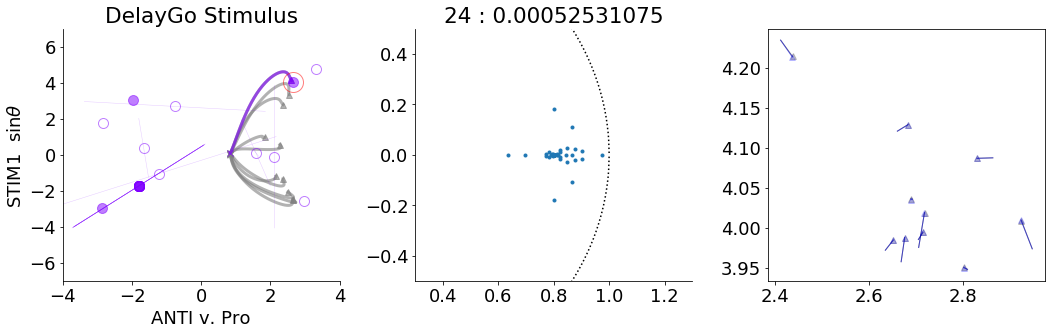

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


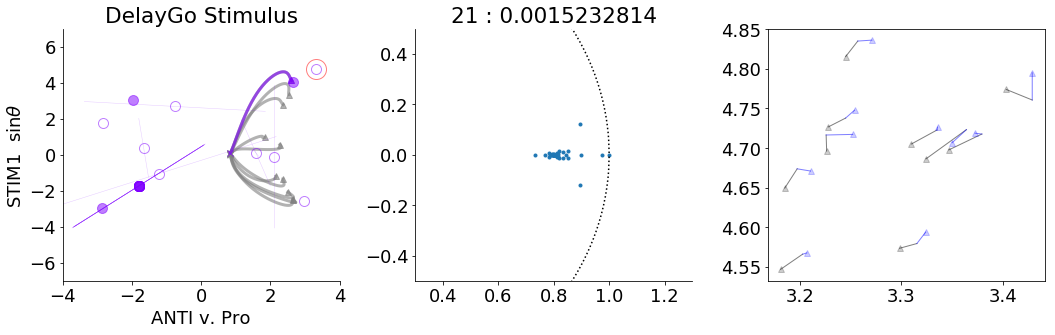

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


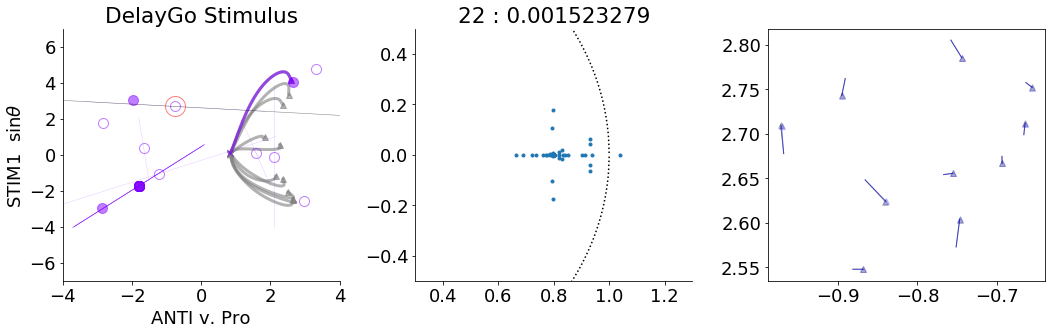

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


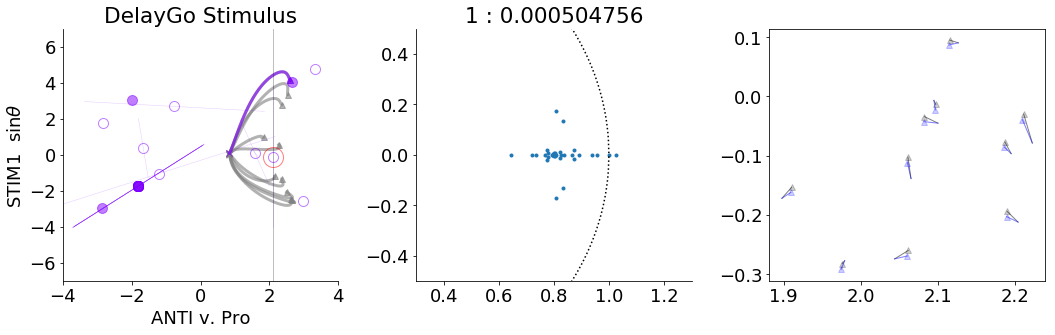

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


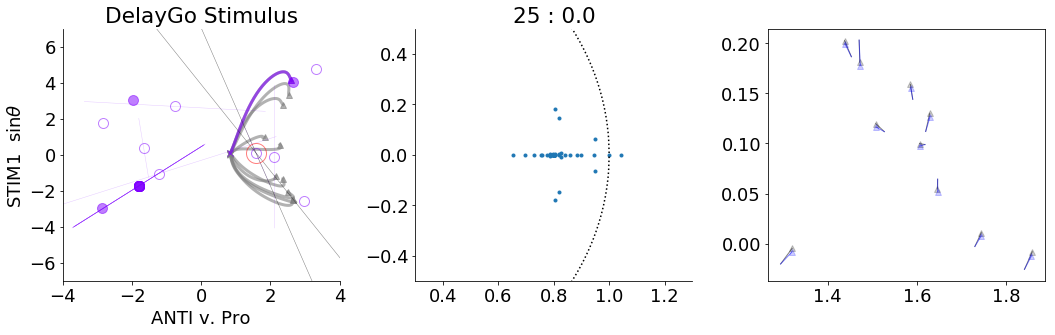

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


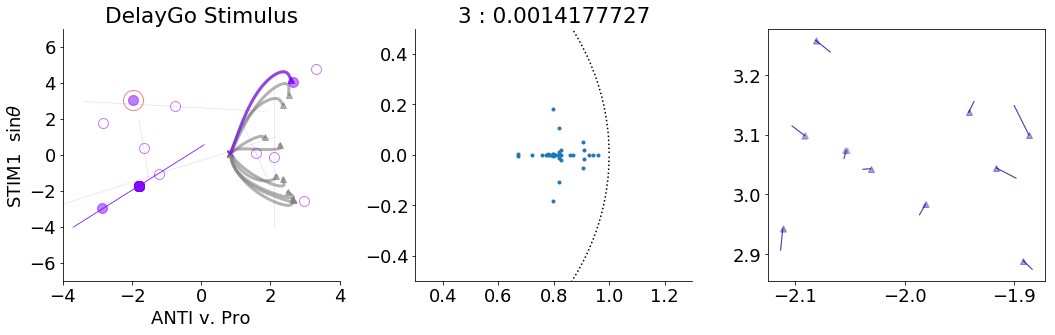

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


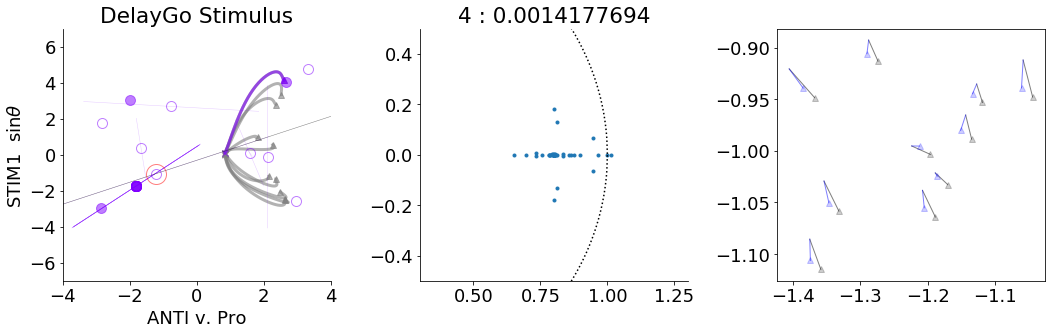

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


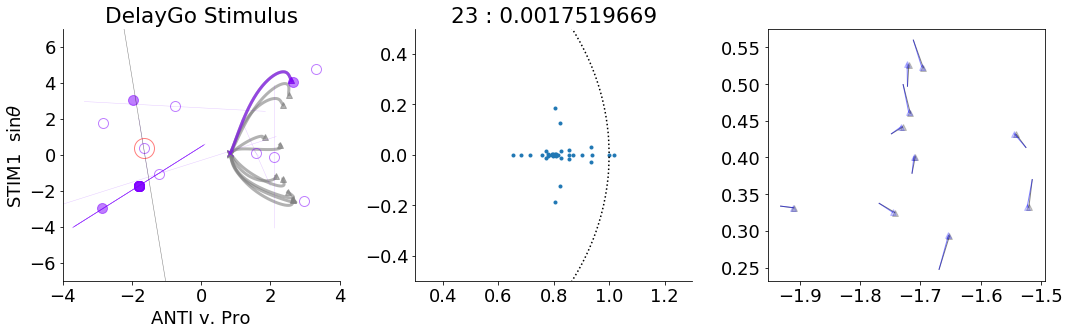

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


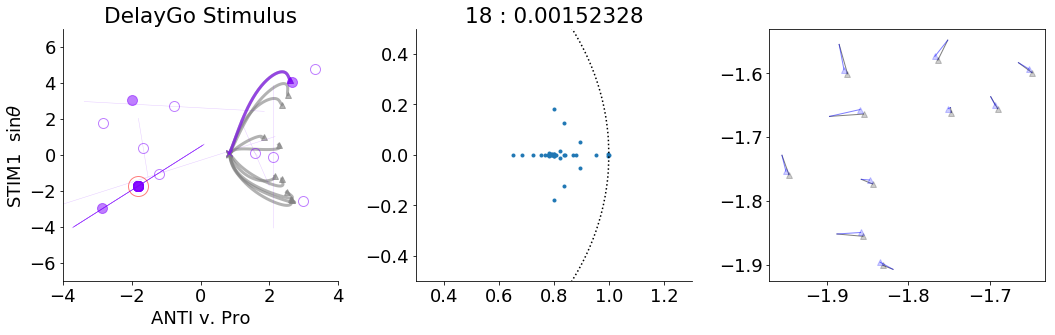

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


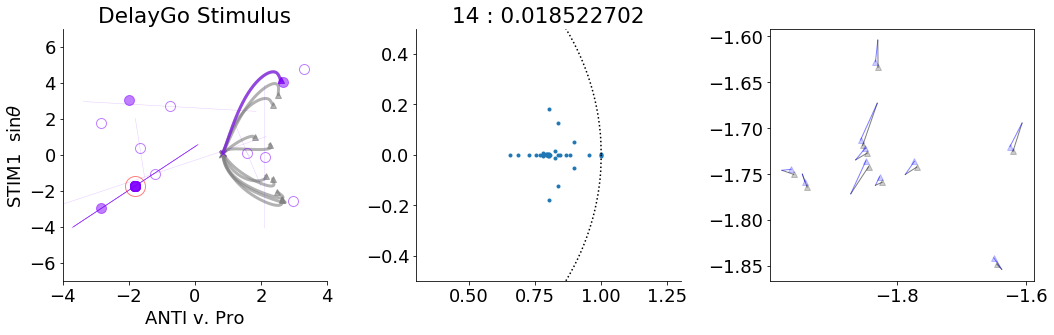

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


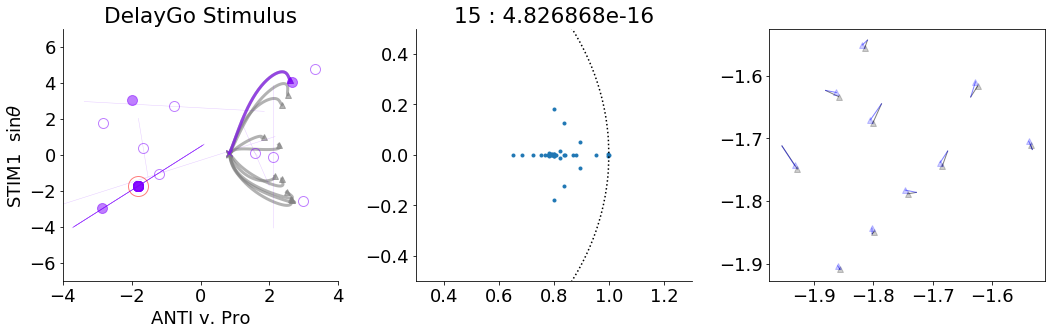

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


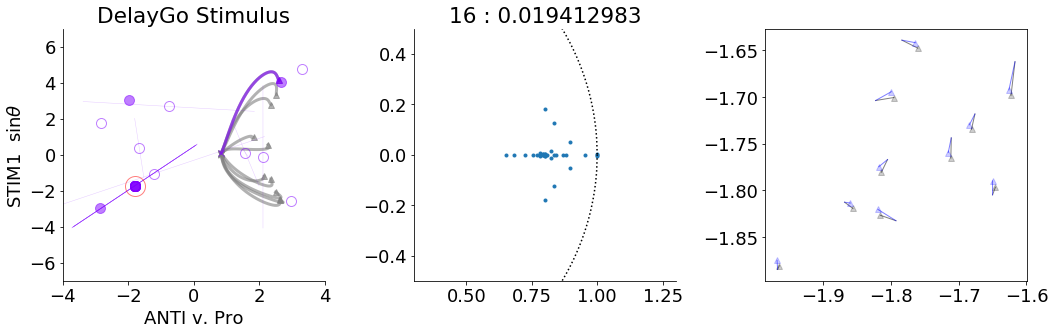

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


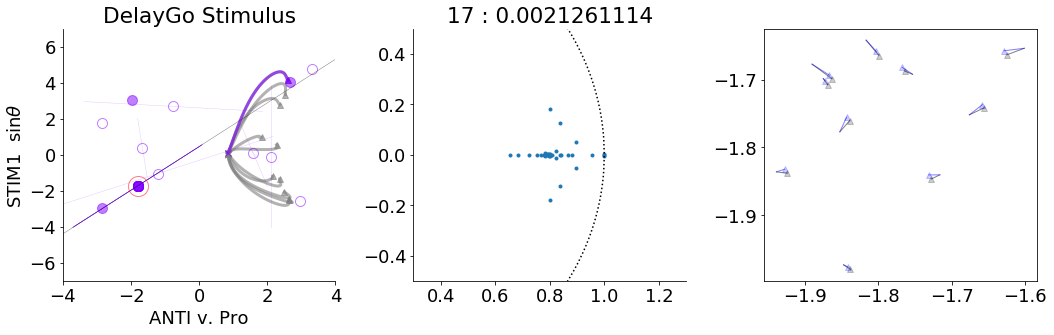

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


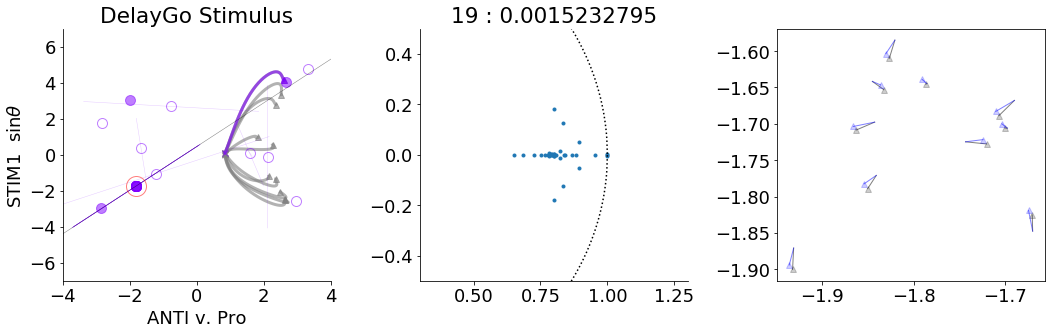

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


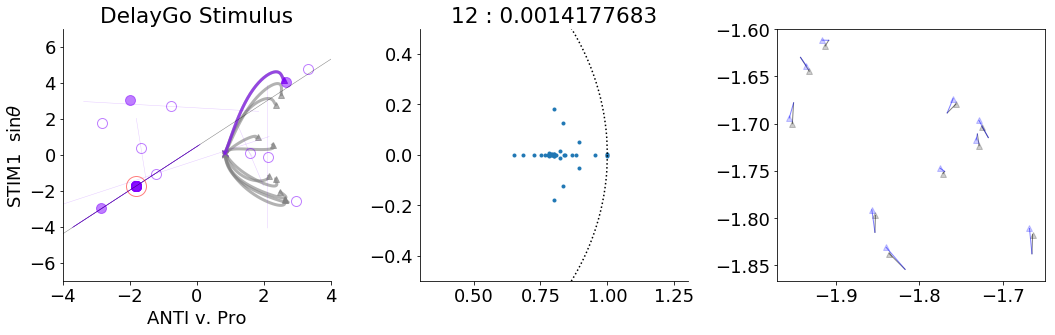

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


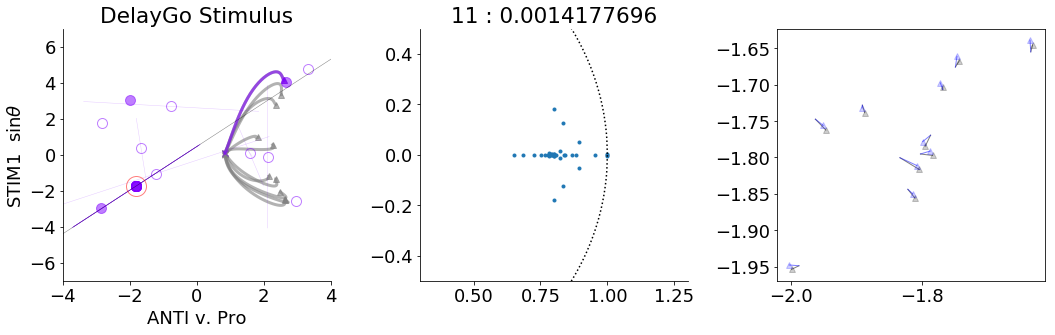

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


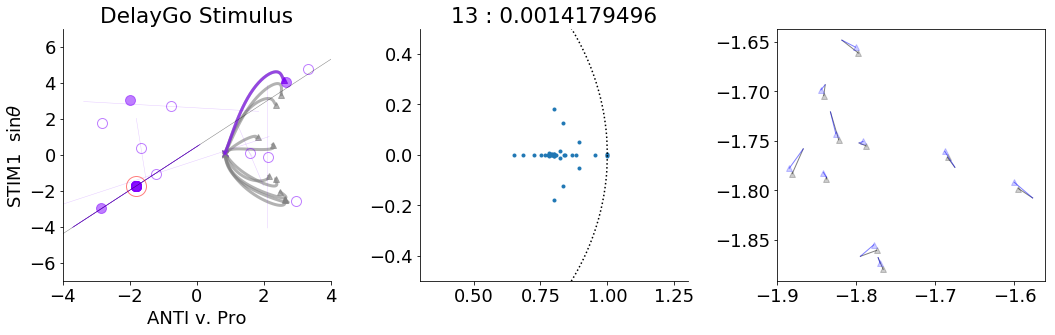

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


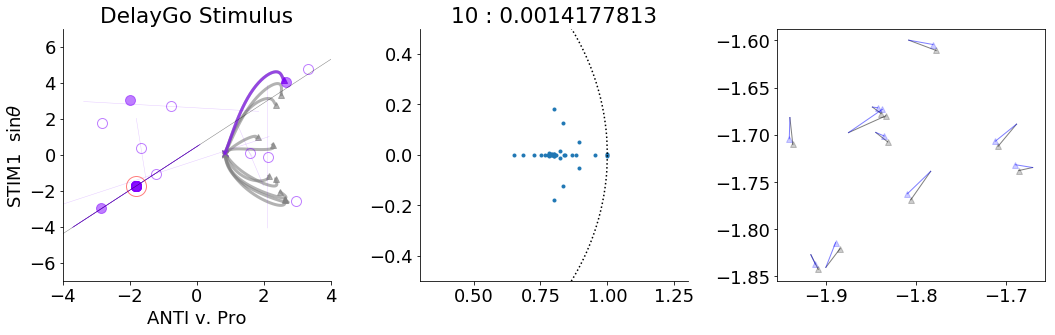

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


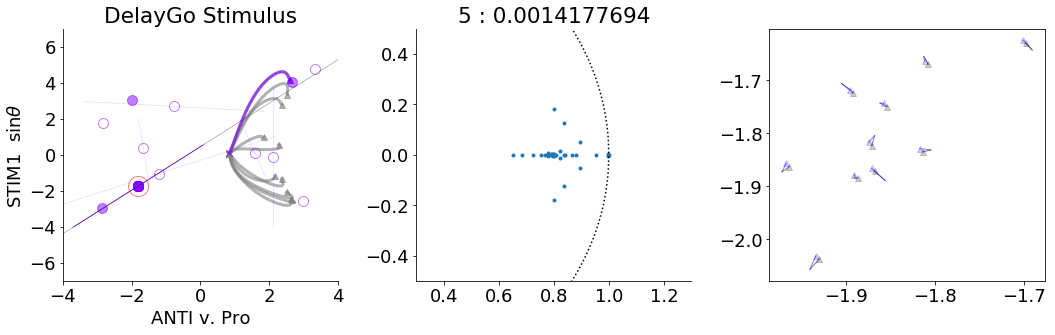

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


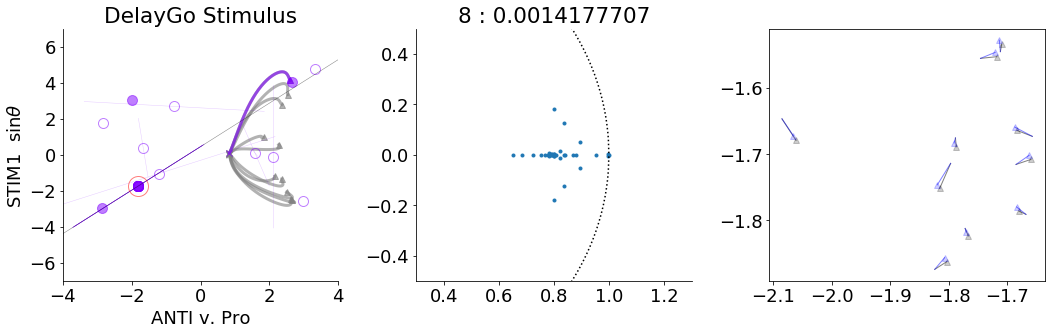

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


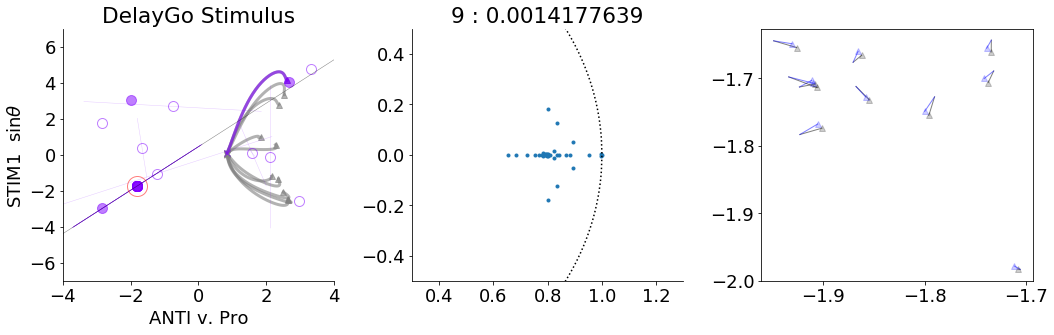

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


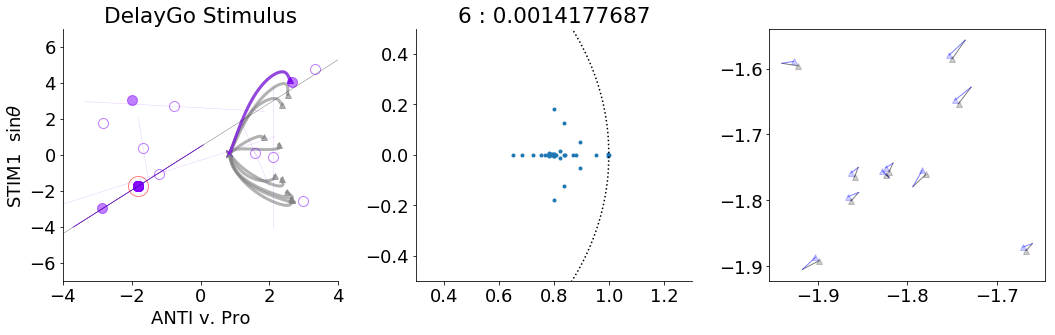

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


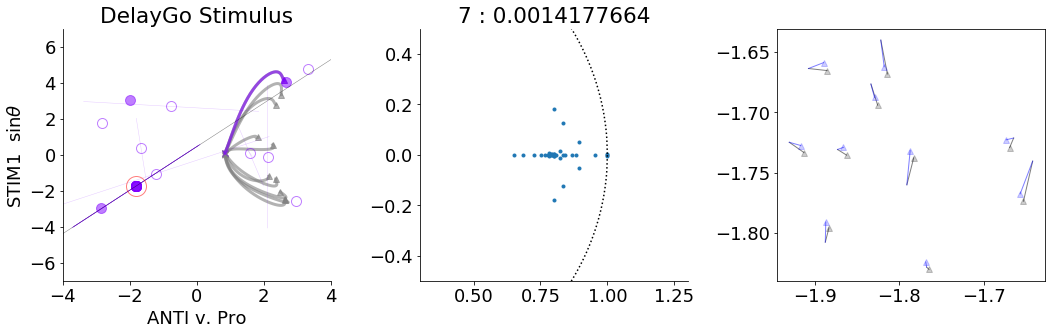

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


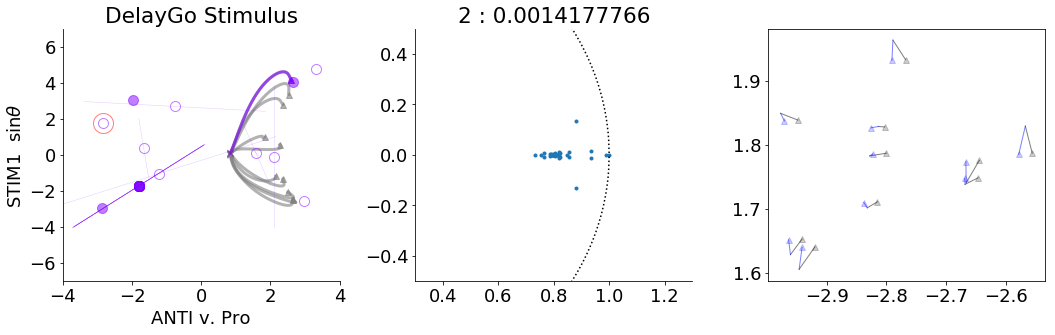

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


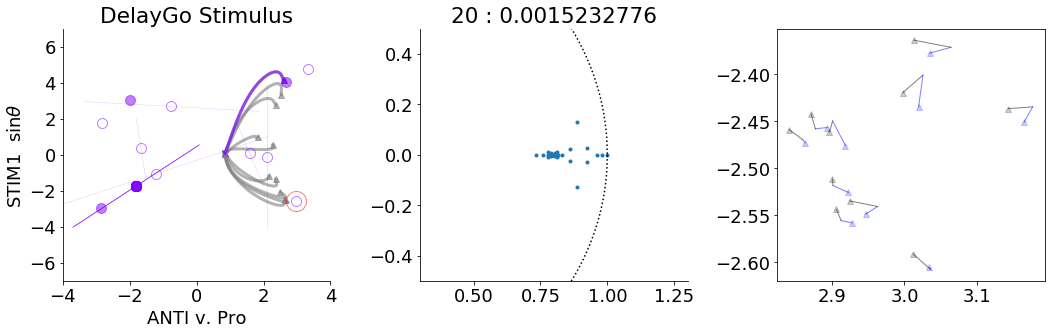

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


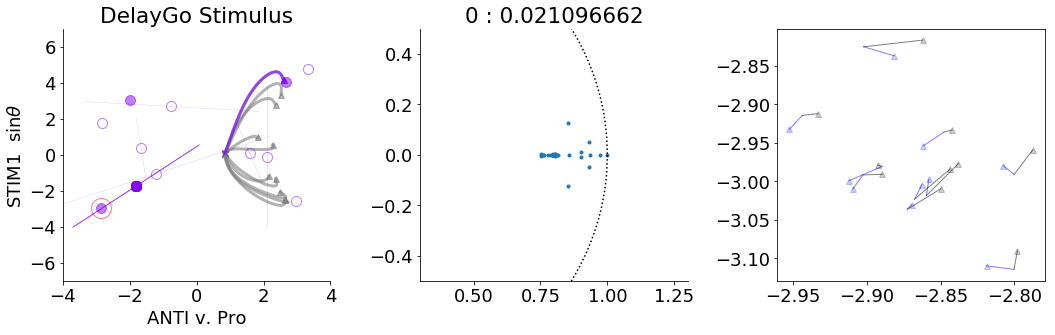

In [84]:
al = .8
lw = 1
t_num = 0
fp_epoch = 'stim1'
qlim = 1
rule_ind = 0
rule_master = rules_dict['all'][rule_ind]
rand_step_coef = 0.1

use_yinds = [0,3]
axes_label1 = Y_labels[use_yinds[0]]
axes_label2 = Y_labels[use_yinds[1]]
D_use = Beta_qr[:,use_yinds]

# axs = 'pca'
# rule_axs = 0
# f = os.path.join(m,'tf_fixed_pts_all_init',rule_set[rule_axs],epoch+'_'+str(t_set[rule_axs])+'.0.npz')
# D_use,_,_ = make_FP_axs(f,m,rule_set[rule_axs],epoch,axs =axs, clust = 'False')
# axes_label1 = 'pca_1'
# axes_label2 = 'pca_2'
# axes_label3 = 'pca_3'

trial = gen_trials_from_model_dir(m,rule_master,mode='test',noise_on = False)
T_inds = get_T_inds(trial,fp_epoch)
_, x = gen_X_from_model_dir(m,trial,d = [])
h_tf = x[:,t_num,T_inds[-1]]

f = os.path.join(m,'tf_fixed_pts_all_init',rule_master,fp_epoch+'_'+str(0)+'.0.npz')
fp_struct = np.load(f)
fp_inds = np.argsort([LA.norm(s - h_tf) for s in fp_struct['xstar']])
sorted_fps = fp_struct['xstar']
eig_decomps = comp_eig_decomp(fp_struct['J_xstar'][:,:,:])
N = np.shape(sorted_fps)[1]

xs = np.linspace(-1, 1, 1000)
ys = np.sqrt(1 - xs**2)

for s in fp_inds:
    fig = plt.figure(figsize=(15,5),tight_layout=True,facecolor='white')
    ax = plt.subplot(1,3,1)
    plot_fp_struct_multicolor(m,[rule_ind],trial_set,D_use,fp_epoch,sorted_fps,eig_decomps,q_star,
                              do_plot_FP=1,t_num = t_num,qlim = qlim)
    plot_FP_specific(s,sorted_fps, D_use.T, eig_decomps, c = 'r') 
    plt.xlabel(axes_label1)
    plt.ylabel(axes_label2)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)  
    plt.ylim((-7,7))    
    plt.xlim((-4,4))
    
    ax = plt.subplot(1,3,2)
    
#     plt.plot([1,1],[-.1,.1],':k')
    plt.plot(eig_decomps[s]['evals'].real,eig_decomps[s]['evals'].imag,'.')
    plt.plot(xs, ys,':k')
    plt.plot(xs, -ys,':k')
    plt.ylim((-.5,.5))    
    plt.xlim((.3,1.3))
    
    plt.title(str(s)+ ' : ' + str(q_star[s]))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)  
    
    n_steps = 5
    ax = plt.subplot(1,3,3)
    
    x_t = np.matlib.repmat(trial.x[T_inds[1],t_num,:],n_steps,1)
    for jit in range(10):
        del_h = rand_step_coef*npr.randn(N)
        h0 = sorted_fps[s,:] + del_h
        
        #nonlinear system
        h_t = vanilla_run_with_h0(params, x_t, h0, hparams)
        jitter = np.dot(h_t,D_use)
        plt.plot(jitter[1,0],jitter[1,1],'^k',linewidth = .1,alpha = .2)
        plt.plot(jitter[:2,0],jitter[:2,1],'-k',linewidth = 1,alpha = .5)
        
        #linear system
        h1 = sorted_fps[s,:] + np.dot(fp_struct['J_xstar'][s,:,:],del_h)
        h_t = np.concatenate((h0[np.newaxis,:],h1[np.newaxis,:]),axis = 0)
        jitter = np.dot(h_t,D_use)
        plt.plot(jitter[1,0],jitter[1,1],'^b',linewidth = .1,alpha = .2)
        plt.plot(jitter[:2,0],jitter[:2,1],'-b',linewidth = 1,alpha = .5)

    plt.show()

In [76]:
use_yinds = [0,3]
axes_label1 = Y_labels[use_yinds[0]]
axes_label2 = Y_labels[use_yinds[1]]
D_use = Beta_qr[:,use_yinds]

In [87]:
rule_master

'fdgo'

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflo

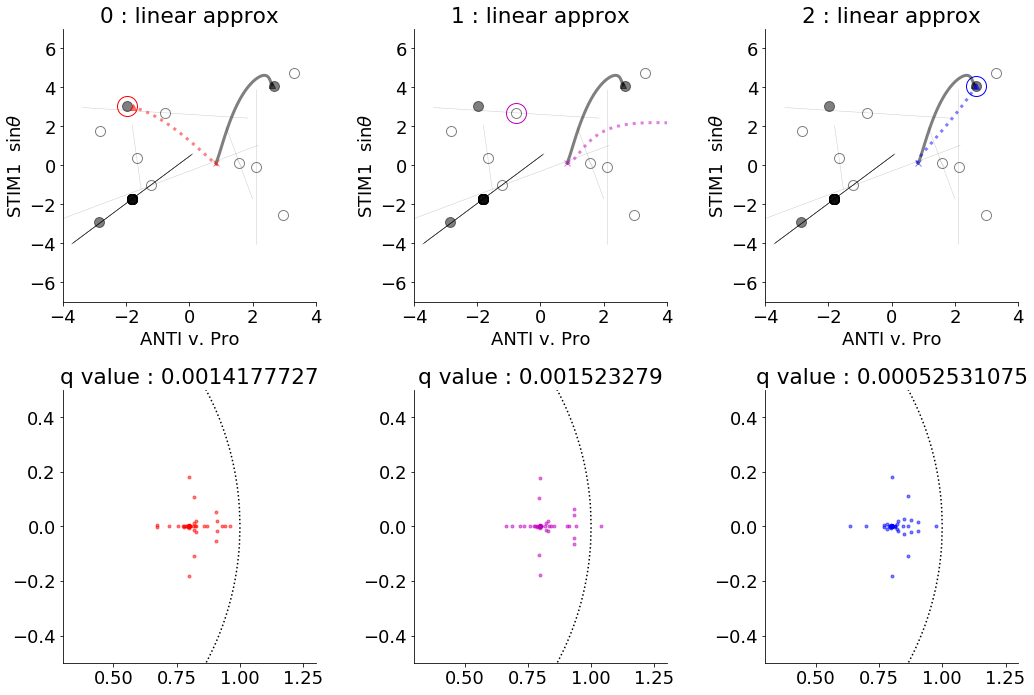

In [88]:
cmap = plt.get_cmap('rainbow')
c_list = np.min(trial.stim_locs[:,[0,2]],axis=1)
c = cmap(c_list[t_num]/(2*np.pi))
FP_proj = np.dot(sorted_fps,D_use)

epoch = 'stim1'

trial = gen_trials_from_model_dir(m,rule_master,mode='test',noise_on = False)

T_inds = get_T_inds(trial,epoch)

_, h_full = gen_X_from_model_dir(m,trial,d = [])

h0 = h_full[:,t_num,T_inds[0]]
x_t = np.matlib.repmat(trial.x[T_inds[1],t_num,:],len(T_inds),1)

# s_set = [24,15,29]#delaygo
s_set = [3,22,24]#fdgo
color_set = ['r', 'm', 'b']
t_num = 0
f = os.path.join(m,'tf_fixed_pts_all_init',rule_master,epoch+'_'+str(t_num)+'.0.npz')
fp_struct = np.load(f)
fp_inds = np.argsort([LA.norm(s - h_tf) for s in fp_struct['xstar']])
sorted_fps = fp_struct['xstar']
eig_decomps = comp_eig_decomp(fp_struct['J_xstar'][:,:,:])

fig = plt.figure(figsize=(15,10),tight_layout=True,facecolor='white')
for si in range(len(s_set)):
    s = s_set[si]
    c = color_set[si]
    
    ax = plt.subplot(2,len(s_set),si+1+len(s_set))
    plt.plot(eig_decomps[s]['evals'].real,eig_decomps[s]['evals'].imag,'.',c=c,alpha = .5)
    plt.plot(xs, ys,':k')
    plt.plot(xs, -ys,':k')
    plt.ylim((-.5,.5))    
    plt.xlim((.3,1.3))
    
    plt.title('q value : ' + str(q_star[s]))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)  
    
    n_steps = len(T_inds)
    ax = plt.subplot(2,len(s_set),si+1)
    
    plot_FP(sorted_fps, D_use.T, eig_decomps)
    
    plt.plot(FP_proj[s,0],FP_proj[s,1],'o',c=c,markerfacecolor = 'None',markersize = 20)
    
    x_t = np.matlib.repmat(trial.x[T_inds[1],t_num,:],n_steps,1)
        
#     #nonlinear system
    h_t = vanilla_run_with_h0(params, x_t, h0, hparams)
    jitter = np.dot(h_t,D_use)
    plt.plot(jitter[-1,0],jitter[-1,1],'^k',linewidth = 3,alpha = .5)
    plt.plot(jitter[:,0],jitter[:,1],'-k',linewidth = 3,alpha = .5)

#     #linear system
    h_t = h0[np.newaxis,:]
    for t in range(n_steps):
        del_h = h_t[-1,:] - fp_struct['xstar'][s,:]
        h1 = fp_struct['xstar'][s,:] + np.dot(fp_struct['J_xstar'][s,:,:],del_h)
        h_t = np.concatenate((h_t,h1[np.newaxis,:]),axis = 0)
    jitter = np.dot(h_t,D_use)
    plt.plot(jitter[0,0],jitter[0,1],'x',c = c,linewidth = 3,alpha = .5)
    plt.plot(jitter[:,0],jitter[:,1],':',c = c,linewidth = 3,alpha = .5)
    plt.plot(jitter[-1,0],jitter[-1,1],'^',c = c,linewidth = 3,alpha = .5)
    
#     ax.xticks('None')
#     ax.yticks('None')
#     
#     ax.spines['left'].set_visible(False)
#     ax.spines['bottom'].set_visible(False)
    plt.xlabel(axes_label1)
    plt.ylabel(axes_label2)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)  
    plt.ylim((-7,7))    
    plt.xlim((-4,4))
    plt.title(str(si) + ' : linear approx')
#     plt.axis('off')

plt.show()

In [66]:
rule_master = 'delaygo'

In [91]:
rule = rule_master

model = FixedPoint_Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    # get all connection weights and biases as tensorflow variables
    var_list = model.var_list
    # evaluate the parameters after training
    params = [sess.run(var) for var in var_list]
    # get hparams
    hparams = model.hp
    # create a trial
    trial = generate_trials(rule, hparams, mode='test', noise_on=False, batch_size=40)# get feed_dict
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    # run model
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)  

    ##################################################################
    # get shapes   
    n_steps, n_trials, n_input_dim = np.shape(trial.x)
    n_rnn = np.shape(h_tf)[2]
    n_output = np.shape(y_hat_tf)[2]

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt


In [27]:
jitter = out_affine(params, h_t[t_ind,:])

In [98]:
np.shape(params[2])

(256, 3)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflo

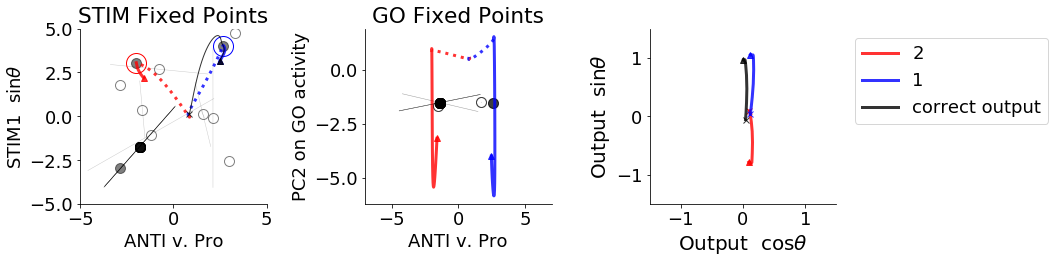

In [117]:
al = .8
from tools_lnd import add_ax_labels, out_axes, out_affine
cmap_discrete = plt.get_cmap('Set1')

n_steps = 100
rule_master = 'fdgo'
epoch = 'stim1'
trial = gen_trials_from_model_dir(m,rule_master,mode='test',noise_on = False)
stim_inds = get_T_inds(trial,epoch)
_, h_full = gen_X_from_model_dir(m,trial,d = [])
h0 = h_full[:,t_num,stim_inds[0]-1]

s_set_labels = [1,2]# [0,1,2]
color_set = ['r','b']#['r', 'm', 'b']
if rule_master=='delaygo':
    s_set = [24,29]#[24,15,29]delaygo
elif rule_master=='fdgo':
    s_set = [3,24]#[3,22,24]fdgo

use_yinds = [0,3]
axes_label1 = Y_labels[use_yinds[0]]
axes_label2 = Y_labels[use_yinds[1]]
D_use = Beta_qr[:,use_yinds]

for t_num in [0,]:#range(0,80,8):
    
    t_theta = (t_num/8)*36

    #STIMULUS PERIOD FIXED POINTS
    f = os.path.join(m,'tf_fixed_pts_all_init',rule_master,epoch+'_'+str(t_theta)+'.npz')
    fp_struct = np.load(f)
    fp_inds = np.argsort([LA.norm(fp_struct['xstar'][s,:] - h_full[:,t_num,-1]) for s in range(len(fp_struct['qstar']))])
    sorted_fps = fp_struct['xstar']
    eig_decomps = comp_eig_decomp(fp_struct['J_xstar'][:,:,:])
    FP_proj = np.dot(sorted_fps,D_use)

    #GO PERIOD FIXED POINTS
    f_go = os.path.join(m,'tf_fixed_pts_all_init',rule_master,'go1'+'_'+str(t_theta)+'.npz')
    fp_struct_go = np.load(f_go)
    sorted_fps_go = fp_struct_go['xstar']
    eig_decomps_go = comp_eig_decomp(fp_struct_go['J_xstar'][:,:,:])
    D_go_fp,_,_ = make_FP_axs(f_go,m,rule_master,'go1',axs ='pca', clust = 'False')
    D_go_h,_,_ = make_FP_axs(f_go,m,rule_master,'go1',axs ='pca_h', clust = 'False')
#     D_go = D_go_h[:,:2]#np.concatenate((D_go_fp[:,:1],D_go_h[:,:1]),axis = 1)
    pc_use = 2
    D_go = np.concatenate((D_use[:,:1],D_go_h[:,(pc_use-1):pc_use]),axis = 1)
    FP_proj_go = np.dot(sorted_fps_go,D_go)
    
    go_inds = get_T_inds(trial,'go1')
    x_t = np.matlib.repmat(trial.x[go_inds[0]+1,t_num,:],len(go_inds),1)
    
    fig = plt.figure(figsize=(15,4),tight_layout=True,facecolor='white')
    ax1 = plt.subplot(1,3,1)
    plot_FP(sorted_fps, D_use.T, eig_decomps)

    for si in range(len(s_set)):
        
        s = s_set[si]
        c = color_set[si]
        
        h_stim = h0[np.newaxis,:]
        for t in range(n_steps):
            h_temp = np.zeros((len(s_set),n_rnn))
            del_h = h_stim[-1,:] - fp_struct['xstar'][s,:]
            h_temp = fp_struct['xstar'][s,:] + np.dot(fp_struct['J_xstar'][s,:,:],del_h)
            h_stim = np.concatenate((h_stim,h_temp[np.newaxis,:]),axis = 0)

        #nonlinear system
        go_ic = h_stim[-1,:]
        h_t = vanilla_run_with_h0(params, x_t, go_ic, hparams)

        ax1 = plt.subplot(1,3,1)
        plt.plot(FP_proj[s,0],FP_proj[s,1],'o',c=c,markerfacecolor = 'None',markersize = 20)

        jitter = np.dot(h_stim,D_use)
        plt.plot(jitter[:,0],jitter[:,1],':',c=c,linewidth = 3,alpha = al,label = str(s_set_labels[si]))

        jitter = np.dot(h_t,D_use)
        plt.plot(jitter[:,0],jitter[:,1],'-',c=c,linewidth = 3,alpha = al,label = str(s_set_labels[si]))
        plt.plot(jitter[-1,0],jitter[-1,1],'^',c=c,linewidth = 3,alpha = al)

        ax2 = plt.subplot(1,3,2)
        plot_FP(sorted_fps_go, D_go.T, eig_decomps_go)

        jitter = np.dot(h_stim,D_go)
        plt.plot(jitter[:,0],jitter[:,1],':',c=c,linewidth = 3,alpha = al,label = str(s_set_labels[si]))

        jitter = np.dot(h_t,D_go)
        plt.plot(jitter[:,0],jitter[:,1],'-',c=c,linewidth = 3,alpha = al,label = str(s_set_labels[si]))
        plt.plot(jitter[-1,0],jitter[-1,1],'^',c=c,linewidth = 3,alpha = al)
        lim = 7
        plt.xlim((-lim,lim))
        plt.xlim((-lim,lim))
        plt.xlabel(axes_label1)
        plt.ylabel('PC'+str(pc_use)+' on GO activity')
        plt.title('GO Fixed Points')
        ax2.spines['right'].set_visible(False)
        ax2.spines['top'].set_visible(False)  

        ax3 = plt.subplot(1,3,3)
        
#         jitter = np.dot(params,h_t.T)
# #         plt.plot(jitter[:,0],jitter[:,1],':',c=c,linewidth = 3,alpha = al)
#         plt.plot(jitter[:,0],jitter[:,1],'-',c=c,linewidth = 3,alpha = al,label = str(str(s_set_labels[si])))
#         plt.plot(jitter[-1,0],jitter[-1,1],'^',c=c,linewidth = 3,alpha = al)
#         plt.plot(jitter[0,0],jitter[0,1],'x',c=c,linewidth = 3,alpha = al)
        
        jitter = np.empty((len(h_t),2))
        for t_ind in range(len(h_t)):
            jitter[t_ind,:] = out_affine(params, h_t[t_ind,:])[1:]
        plt.plot(jitter[:,0],jitter[:,1],'-',c=c,linewidth = 3,alpha = al,label = str(str(s_set_labels[si])))
        plt.plot(jitter[-1,0],jitter[-1,1],'^',c=c,linewidth = 3,alpha = al)
        plt.plot(jitter[0,0],jitter[0,1],'x',c=c,linewidth = 3,alpha = al)
    
    h_go = h_full[:,:,stim_inds[-1]:]
    jitter = np.empty((np.shape(h_go)[2],2))
    for t_ind in range(np.shape(h_go)[2]):
#         jitter[t_ind,:] = out_affine(params, h_go[:,t_num,t_ind])
        jitter[t_ind,:] = np.dot(params[2].T,h_go[:,t_num,t_ind])[1:]
    plt.plot(jitter[:,0],jitter[:,1],'-k',linewidth = 3,alpha = al,label = 'correct output')
    plt.plot(jitter[-1,0],jitter[-1,1],'^k',linewidth = 3,alpha = al)
    plt.plot(jitter[0,0],jitter[0,1],'xk',linewidth = 3,alpha = al)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    out_axes(ax3)

    ax1 = plt.subplot(1,3,1)
    jitter = np.dot(h_full[:,t_num,stim_inds[0]:].T,D_use)
    plt.plot(jitter[:,0],jitter[:,1],'-k',linewidth = 1,alpha = al,label = 'full system')
    plt.plot(jitter[-1,0],jitter[-1,1],'^k',linewidth = 3,alpha = al)
    plt.plot(jitter[0,0],jitter[0,1],'xk',linewidth = 3,alpha = al)
    plt.ylim((-5,5))
    plt.xlim((-5,5))    
    plt.xlabel(axes_label1)
    plt.ylabel(axes_label2)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)  
    plt.title('STIM Fixed Points')

    
    tit = 'single_FP_approx'

    if not os.path.exists(os.path.join(figpath,tit)):
        os.makedirs(os.path.join(figpath,tit))
    figname = tit+'_'+str(t_num)
    plt.savefig(os.path.join(figpath,tit,figname+'.pdf'))
    plt.savefig(os.path.join(figpath,tit,figname+'.png'))
    plt.show()


0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflo

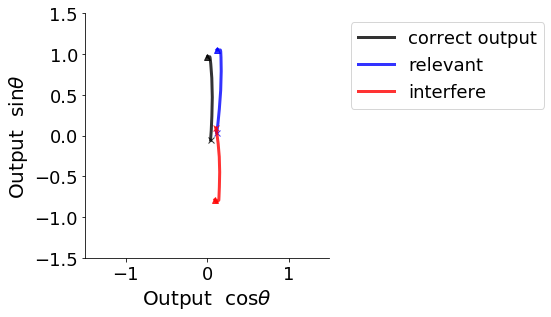

In [129]:
al = .8
from tools_lnd import add_ax_labels, out_axes, out_affine
cmap_discrete = plt.get_cmap('Set1')

n_steps = 100
rule_master = 'fdgo'
epoch = 'stim1'
trial = gen_trials_from_model_dir(m,rule_master,mode='test',noise_on = False)
stim_inds = get_T_inds(trial,epoch)
_, h_full = gen_X_from_model_dir(m,trial,d = [])
h0 = h_full[:,t_num,stim_inds[0]-1]

s_set_labels = [1,2]# [0,1,2]
color_set = ['r','b']#['r', 'm', 'b']
fp_labels = ['interfere','relevant']
if rule_master=='delaygo':
    s_set = [24,29]#[24,15,29]delaygo
elif rule_master=='fdgo':
    s_set = [3,24]#[3,22,24]fdgo

use_yinds = [0,3]
axes_label1 = Y_labels[use_yinds[0]]
axes_label2 = Y_labels[use_yinds[1]]
D_use = Beta_qr[:,use_yinds]

for t_num in [0,]:#range(0,80,8):
    
    t_theta = (t_num/8)*36

    go_inds = get_T_inds(trial,'go1')
    x_t = np.matlib.repmat(trial.x[go_inds[0]+1,t_num,:],len(go_inds),1)
    
    fig = plt.figure(figsize=(8,8),tight_layout=True,facecolor='white')
    ax3 = plt.subplot(1,1,1)
    
    h_go = h_full[:,:,stim_inds[-1]:]
    jitter = np.empty((np.shape(h_go)[2],2))
    for t_ind in range(np.shape(h_go)[2]):
#         jitter[t_ind,:] = out_affine(params, h_go[:,t_num,t_ind])
        jitter[t_ind,:] = np.dot(params[2].T,h_go[:,t_num,t_ind])[1:]
    plt.plot(jitter[:,0],jitter[:,1],'-k',linewidth = 3,alpha = al,label = 'correct output')
    plt.plot(jitter[-1,0],jitter[-1,1],'^k',linewidth = 3,alpha = al)
    plt.plot(jitter[0,0],jitter[0,1],'xk',linewidth = 3,alpha = al)
    
    for si in [1,0]:
        
        s = s_set[si]
        c = color_set[si]
        
        h_stim = h0[np.newaxis,:]
        for t in range(n_steps):
            h_temp = np.zeros((len(s_set),n_rnn))
            del_h = h_stim[-1,:] - fp_struct['xstar'][s,:]
            h_temp = fp_struct['xstar'][s,:] + np.dot(fp_struct['J_xstar'][s,:,:],del_h)
            h_stim = np.concatenate((h_stim,h_temp[np.newaxis,:]),axis = 0)

        #nonlinear system
        go_ic = h_stim[-1,:]
        h_t = vanilla_run_with_h0(params, x_t, go_ic, hparams)
        
        jitter = np.empty((len(h_t),2))
        for t_ind in range(len(h_t)):
            jitter[t_ind,:] = out_affine(params, h_t[t_ind,:])[1:]
        plt.plot(jitter[:,0],jitter[:,1],'-',c=c,linewidth = 3,alpha = al,label = fp_labels[si])
        plt.plot(jitter[-1,0],jitter[-1,1],'^',c=c,linewidth = 3,alpha = al)
        plt.plot(jitter[0,0],jitter[0,1],'x',c=c,linewidth = 3,alpha = al)

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    out_axes(ax3)
    ax3.set_aspect('equal', adjustable='box')
    tit = 'single_FP_approx'

    if not os.path.exists(os.path.join(figpath,tit)):
        os.makedirs(os.path.join(figpath,tit))
    figname = tit+'_'+str(t_num)
    plt.savefig(os.path.join(figpath,tit,figname+'.pdf'))
    plt.savefig(os.path.join(figpath,tit,figname+'.png'))
    plt.show()


In [122]:
os.path.join(figpath,tit,figname+'.pdf')

'/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v1_figs/identify_rel_fps/single_FP_approx/single_FP_approx_0.pdf'

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflo

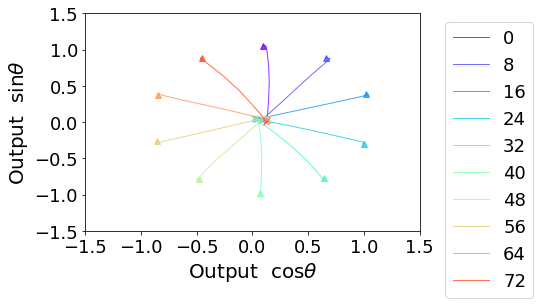

In [113]:
n_steps = 100
rule_master = 'fdgo'
epoch = 'stim1'
trial = gen_trials_from_model_dir(m,rule_master,mode='test',noise_on = False)
stim_inds = get_T_inds(trial,epoch)
_, h_full = gen_X_from_model_dir(m,trial,d = [])
cmap = plt.get_cmap('rainbow')

h_go = h_full[:,:,stim_inds[-1]:]

w_in, b_in, w_out, b_out = get_model_params(m)

for t_num in range(0,80,8):
    
    jitter = np.empty((np.shape(h_go)[2],2))
    for t_ind in range(np.shape(h_go)[2]):
        X = h_go[:,t_num,t_ind]
        jitter[t_ind,:] = np.dot(X.T, w_out[:,1:]) + b_out[1:]
#         jitter[t_ind,:] = np.dot(params[2].T,h_go[:,t_num,t_ind])

    plt.plot(jitter[:,0],jitter[:,1],'-',c = cmap(t_num/80),linewidth = 1,alpha = al,label = str(t_num))
    plt.plot(jitter[-1,0],jitter[-1,1],'^',c = cmap(t_num/80),linewidth = 3,alpha = al)
    plt.plot(jitter[0,0],jitter[0,1],'x',c = cmap(t_num/80),linewidth = 3,alpha = al)
    
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
out_axes(ax3)

In [107]:
def project_to_output(model_dir_all,X):
    w_in, b_in, w_out, b_out = get_model_params(model_dir_all)
    y = np.dot(X.T, w_out) + b_out
    return y

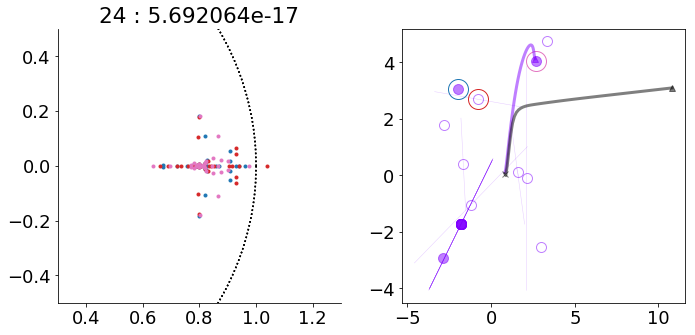

In [97]:
cmap = plt.get_cmap('rainbow')
cmap_discrete = plt.get_cmap('tab10')
c_list = np.min(trial.stim_locs[:,[0,2]],axis=1)
c = cmap(c_list[t_num]/(2*np.pi))
FP_proj = np.dot(sorted_fps,D_use)
s_set = [3,22,24]#[26,15,41,43,44,29]#29

fig = plt.figure(figsize=(10,5),tight_layout=True,facecolor='white')

ax = plt.subplot(1,2,1)

for si in range(len(s_set)):
    s = s_set[si]
    plt.plot(eig_decomps[s]['evals'].real,eig_decomps[s]['evals'].imag,'.',c = cmap_discrete(si/len(s_set)))
    plt.plot(xs, ys,':k')
    plt.plot(xs, -ys,':k')
    
plt.ylim((-.5,.5))    
plt.xlim((.3,1.3))
plt.title(str(s)+ ' : ' + str(q_star[s]))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)  

n_steps = len(T_inds)
ax = plt.subplot(1,2,2)

plot_FP(sorted_fps, D_use.T, eig_decomps,c = c)
for si in range(len(s_set)):
    s = s_set[si]
    plt.plot(FP_proj[s,0],FP_proj[s,1],'o',c = cmap_discrete(si/len(s_set)),
             markerfacecolor = 'None',markersize = 20,linewidth = 7)

x_t = np.matlib.repmat(trial.x[T_inds[1],t_num,:],n_steps,1)

#     #nonlinear system
h0 = h_full[:,t_num,T_inds[0]]
h_t = vanilla_run_with_h0(params, x_t, h0, hparams)
jitter = np.dot(h_t,D_use)
plt.plot(jitter[-1,0],jitter[-1,1],'^',c=c,linewidth = 3,alpha = .5)
plt.plot(jitter[:,0],jitter[:,1],'-',c=c,linewidth = 3,alpha = .5)

#     linear system
#     h0 = fp_struct['xstar'][s,:] + rand_step_coef*npr.randn(N)
h0 = h_full[:,t_num,T_inds[0]-1]
h_t = h0[np.newaxis,:]

for t in range(n_steps):
    h_temp = np.zeros((len(s_set),n_rnn))
    
    for si in range(len(s_set)):
        s = s_set[si]
        del_h = h_t[-1,:] - fp_struct['xstar'][s,:]
        h_temp[si,:] = fp_struct['xstar'][s,:] + np.dot(fp_struct['J_xstar'][s,:,:],del_h) - h_t[-1,:]
        
    h1 = h_t[-1,:]+ np.sum(h_temp,axis = 0)
    h_t = np.concatenate((h_t,h1[np.newaxis,:]),axis = 0)
    
jitter = np.dot(h_t,D_use)
plt.plot(jitter[0,0],jitter[0,1],'xk',linewidth = 3,alpha = .5)
plt.plot(jitter[:,0],jitter[:,1],'-k',linewidth = 3,alpha = .5)
plt.plot(jitter[-1,0],jitter[-1,1],'^k',linewidth = 3,alpha = .5)

plt.show()

In [ ]:
def plot_initXtasks(rule_ic_set, rule_in_set, c):
    
    output_labels = ['fixation',r' $\sin{\theta}$',r' $\cos{\theta}$']

    for rule_ic in rule_ic_set['set']:
        t_ind = trial_all[rule_ic].epochs['fix1'][1]-1
        b = 0 #trial number for now
        h0 = h_all[rule_ic][t_ind,b,:]

        for rule_in in rule_in_set['set']:
            t_start = trial_all[rule_in].epochs['fix1'][1]
            t_end = len(trial_all[rule_in].x)
            n_steps = t_end - t_start

            h_t = np.empty((n_steps,n_rnn))
            y_hat = np.empty((n_steps,n_output))
            x_t = trial_all[rule_in].x[range(t_start,t_end),b,:]
            h = h0
            for ti in range(t_end-t_start):
                h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x_t[ti,:]), alpha)
                h_t[ti,:] = h
                y_hat[ti,:] = out_affine(params, h_t[ti,:])

            for out_ind in range(n_output):
                ax = plt.subplot(1,3,out_ind+1)
                plt.plot(y_hat[:,out_ind],c,label = rule_ic + ' ic', alpha = .2,linewidth = 2)
                plt.plot(trial_all[rule_in].y[t_start:t_end,b,out_ind],':'+c,label = rule_in + ' target',linewidth = 2)
                plt.text(0,-.5,output_labels[out_ind])
                plt.ylim((-1.2,1.2))
                
                ax.spines['right'].set_visible(False)
                ax.spines['top'].set_visible(False)
                if out_ind == 1:
                    plt.title(rule_ic_set['set_name']+' ic, '+ rule_in_set['set_name']+ ' input')
                    plt.legend(('ouput','target'),fontsize = 14)
                else:
                    ax.spines['left'].set_visible(False)
                    ax.spines['bottom'].set_visible(False)
                    ax.get_xaxis().set_ticks([])
                    ax.get_yaxis().set_ticks([])

In [ ]:
fdgo_tasks = {'set_name':'DelayPro','set':['fdgo',]}
fdanti_tasks = {'set_name':'DelayAnti','set':['fdanti',]}
delay_tasks = {'set_name':['DelayPro','DelayAnti'],'set':['fdgo','fdanti']}

In [ ]:
plt.rcParams.update({'font.size': 18})

fig = plt.figure(figsize=(6, 2.5))
plot_initXtasks(fdgo_tasks, fdanti_tasks, 'g')
figname = 'fdgoIN_example_output.pdf'
plt.savefig(os.path.join(figpath,figname), bbox_inches = 'tight')
plt.show()

fig = plt.figure(figsize=(6, 2.5))
plot_initXtasks(fdanti_tasks, fdgo_tasks, 'r')
figname = 'fdantiIN_example_output.pdf'
plt.savefig(os.path.join(figpath,figname), bbox_inches = 'tight')
plt.show()

In [ ]:
def quant_perf(rule_ic_set, rule_in_set):
    for rule_ic in rule_ic_set['set']:
        t_ind = trial_all[rule_ic].epochs['fix1'][1]-1
        
        ri = 0
        for rule_in in rule_in_set['set']:
            t_start = trial_all[rule_in].epochs['fix1'][1]
            t_end = len(trial_all[rule_in].x)
            n_steps = t_end - t_start

            n_trials = trial_all[rule_in].x.shape[1]
            
            y_locs = trial_all[rule_in].y_loc[t_start:,:]
            y_hat = np.empty((n_steps,n_trials,n_output))
            
            for b in range(n_trials):
                h0 = h_all[rule_ic][t_ind,0,:]
                h_t = np.empty((n_steps,n_rnn))
                x_t = trial_all[rule_in].x[range(t_start,t_end),b,:]
                h = h0
                for ti in range(t_end-t_start):
                    h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x_t[ti,:]), alpha)
                    h_t[ti,:] = h
                    y_hat[ti,b,:] = out_affine(params, h_t[ti,:])

            perf = get_perf(y_hat, y_locs)
            plt.plot(ri,np.mean(perf),'ok', alpha = .5)
            ri+=1
            
        plt.xticks(range(len(rule_in_set['set'])), rule_in_set['set'],rotation = 45)
        plt.ylim((-.1,1.1))
        plt.xlim((-.5,ri-.5))
        plt.title(rule_ic + ' ICs')

In [ ]:
fig = plt.figure(figsize=(6, 3))

# for model_n_temp in range(5):
model_n_temp = model_n
m_temp = os.path.join(p,'data/rnn/multitask/',net,dir_specific_all,str(model_n_temp))
h_all,trial_all,tasks_all = make_h_trial_rule(m_temp,mode = 'random',noise_on = True)

ax1 = plt.subplot(1,2,1)
quant_perf(fdgo_tasks, delay_tasks)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
plt.ylabel('performance')

ax2 = plt.subplot(1,2,2)
quant_perf(fdanti_tasks, delay_tasks)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.set_yticks([])

figname = 'quant_perf.pdf'
plt.savefig(os.path.join(figpath,figname), bbox_inches = 'tight')
plt.show()

In [255]:
m

'/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0'

In [ ]:
#troubleshoot fp finder

In [ ]:
rule = 'fdanti'

model = FixedPoint_Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    # get all connection weights and biases as tensorflow variables
    var_list = model.var_list
    # evaluate the parameters after training
    params = [sess.run(var) for var in var_list]
    # get hparams
    hparams = model.hp
    # create a trial
    trial = generate_trials(rule, hparams, mode='test', noise_on=False, batch_size=40)# get feed_dict
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    # run model
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)  

    ##################################################################
    # get shapes   
    n_steps, n_trials, n_input_dim = np.shape(trial.x)
    n_rnn = np.shape(h_tf)[2]
    n_output = np.shape(y_hat_tf)[2]


    n_epochs = len(trial.epochs)
    for epoch in range(n_epochs):
        e_start = max([0, trial.epochs.values()[epoch][0]])
        end_set = [n_steps, trial.epochs.values()[epoch][1]]
        e_end = min(x for x in end_set if x is not None)

        n_inputs = 0
        input_set = {str(n_inputs) : np.zeros((1,n_input_dim))}

        for t in range(0,n_trials,int(n_trials/10)):#[int(n_trials/2),]:#:

            inputs = np.squeeze(trial.x[e_start,t,:])
            inputs = inputs[np.newaxis,:]
            inputs_big = inputs[np.newaxis,:]

            unique_input, input_set = add_unique_to_inputs_list(input_set, str(n_inputs), inputs)

            if unique_input:
                n_inputs+=1
                input_set[str(n_inputs)] = inputs

                plt.plot(inputs)

